# Digit Image Classification

The goal is to classify images of size 32x32 into 5 disctinct categories : '1', '2', '3', '4', '5'



My Contribution is here:
    
1. Data Augmentation

2. Used Batch Normalization, Dropout for regularization

3. Adam optimizer to optimize network  during training

4. Hyperparameter tuning to find best model

5. Callback class that stops training once accuracy reaches 99.9%
Generated classification report

6. Analyzed predictions by plotting 


## Importing libraries

In [1]:
import keras
from keras.models import Sequential,Input,Model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

import os
import cv2
import numpy as np
import tensorflow as tf
import math
from random import randint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from IPython.display import SVG

Using TensorFlow backend.


## Loading the images and looking at some data

In [2]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == '1': 
            label = 0
        elif labels == '2':
            label = 1
        elif labels == '3':
            label = 2
        elif labels == '4':
            label = 3
        elif labels == '5':
            label = 4
       
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(28,28)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5'}
    
    return labels[class_code]

In [3]:
Images, Labels = get_images('train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

Lets find shape of our traing data.
As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.

In [4]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (40112, 28, 28, 3)
Shape of Labels: (40112,)


## Inspection of the data

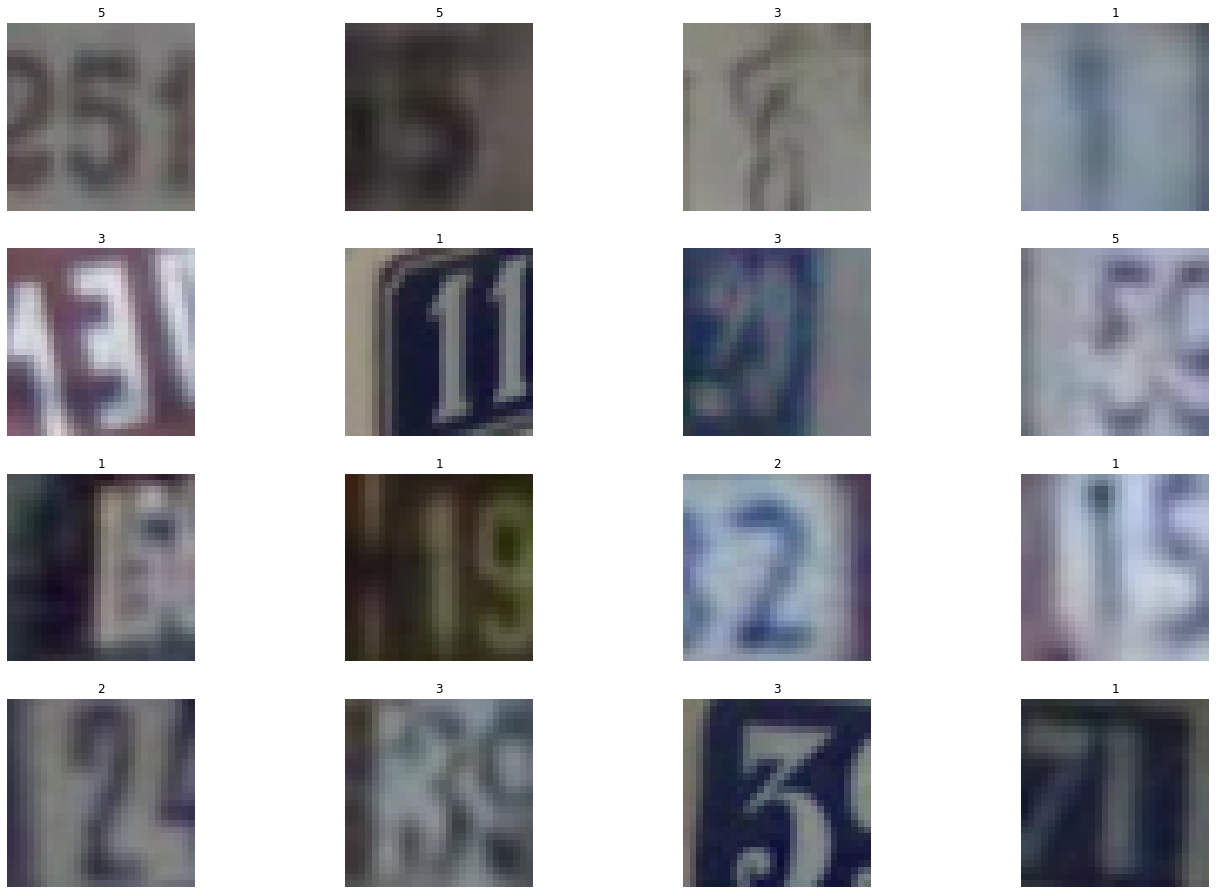

In [5]:
f,ax = plt.subplots(4,4) 
f.subplots_adjust(0,0,3,3)
for i in range(0,4,1):
    for j in range(0,4,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

## Preparation of the data generators

In [6]:
train_data_path = 'train'
test_data_path = 'test'

size=(28,28)
epochs = 10
batch_size = 20

#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)





Found 40112 images belonging to 5 classes.
Found 17037 images belonging to 5 classes.


In [7]:
num_of_train_samples = 40112
num_of_test_samples = 17037

## Creating the model

**A simple model with

4 conv layer with Relu activation

2 Maxpooling layer

5 BatchNormalization layer

2 Dense layer

1 Flatten layer

1 Dropout Layer

**

## Trying a more powerful model

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization(axis=-1)

model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))

BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(5))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 10, 64)        0         
__________

In [13]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True


In [14]:
callbacks = myCallback()
training_1= model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = num_of_train_samples // batch_size,
            epochs = 50,
            validation_steps = num_of_test_samples // batch_size,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/50
 - 124s - loss: 1.3861 - acc: 0.3446 - val_loss: 1.8508 - val_acc: 0.4095
Epoch 2/50
 - 126s - loss: 1.1466 - acc: 0.5040 - val_loss: 1.2051 - val_acc: 0.6230
Epoch 3/50
 - 124s - loss: 0.9513 - acc: 0.6047 - val_loss: 1.1554 - val_acc: 0.6664
Epoch 4/50
 - 115s - loss: 0.8734 - acc: 0.6481 - val_loss: 1.1196 - val_acc: 0.6872
Epoch 5/50
 - 121s - loss: 0.8207 - acc: 0.6760 - val_loss: 1.0635 - val_acc: 0.6932
Epoch 6/50
 - 147s - loss: 0.7771 - acc: 0.6958 - val_loss: 0.9776 - val_acc: 0.6903
Epoch 7/50
 - 126s - loss: 0.7385 - acc: 0.7182 - val_loss: 0.9230 - val_acc: 0.7178
Epoch 8/50
 - 130s - loss: 0.7029 - acc: 0.7355 - val_loss: 0.9761 - val_acc: 0.7208
Epoch 9/50
 - 129s - loss: 0.6832 - acc: 0.7426 - val_loss: 0.8992 - val_acc: 0.7310
Epoch 10/50
 - 126s - loss: 0.6584 - acc: 0.7535 - val_loss: 0.7855 - val_acc: 0.7438
Epoch 11/50
 - 198s - loss: 0.6403 - acc: 0.7631 - val_loss: 0.8378 - val_acc: 0.7359
Epoch 12/50
 - 207s - loss: 0.6227 - acc: 0.7710 - val_loss: 0.

In [15]:
model.save('model/model-1.h5')

# Analysis of the predictions

In [16]:
#Form a prediction set
from keras import models 

validation_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False)



model1 = models.load_model('model/model-1.h5')

Y_pred = model1.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred_bool = np.argmax(Y_pred, axis=1)

# generate classification report
from sklearn import metrics

#print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(validation_generator.classes,y_pred_bool))


Found 17037 images belonging to 5 classes.
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5099
           1       0.82      0.91      0.86      4149
           2       0.71      0.85      0.77      2882
           3       0.95      0.33      0.49      2523
           4       0.84      0.87      0.85      2384

    accuracy                           0.82     17037
   macro avg       0.83      0.78      0.77     17037
weighted avg       0.83      0.82      0.80     17037



In [18]:
c=0
for i in range(len(validation_generator.classes)):
  if validation_generator.classes[i]==y_pred_bool[i]:
    c+=1
    
print("Accuracy")
print(c/len(y_pred_bool))

conf_mx=confusion_matrix(validation_generator.classes, y_pred_bool)
print('Confusion Matrix')
print(conf_mx)

Accuracy
0.8161648177496038
Confusion Matrix
[[4795  109  126   29   40]
 [  81 3760  193    3  112]
 [  93  157 2449    7  176]
 [ 658  496  470  826   73]
 [  21   79  205    4 2075]]


In [19]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

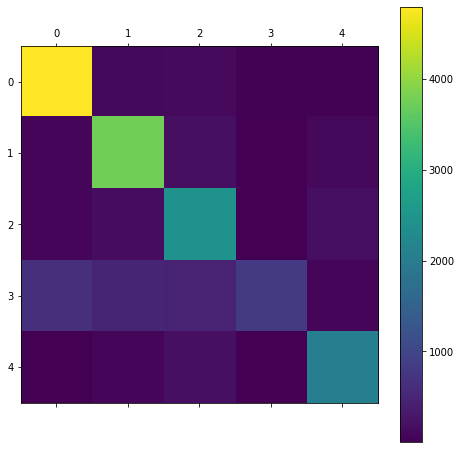

In [20]:
plot_confusion_matrix(conf_mx)

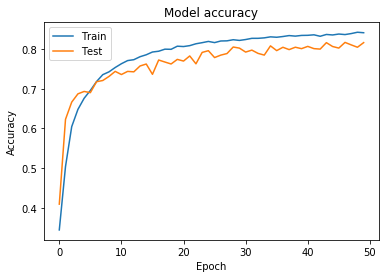

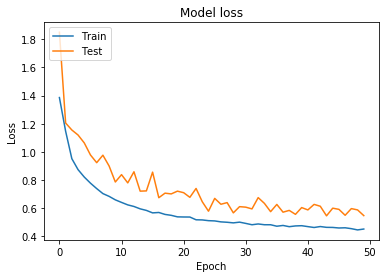

In [21]:
plt.plot(training_1.history['acc'])
plt.plot(training_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(training_1.history['loss'])
plt.plot(training_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

There is no obvious overfitting.The best way to check if the model is overfitting or underfitting is the loss error.
If the validation loss is increasing but your training loss is still decreasing is that the model is not generalizing and it is overfitting

In [22]:
pred_images,no_labels = get_images('test/')
pred_images = np.array(pred_images)
pred_images.shape

(17037, 28, 28, 3)

/Users/mosthusnejahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


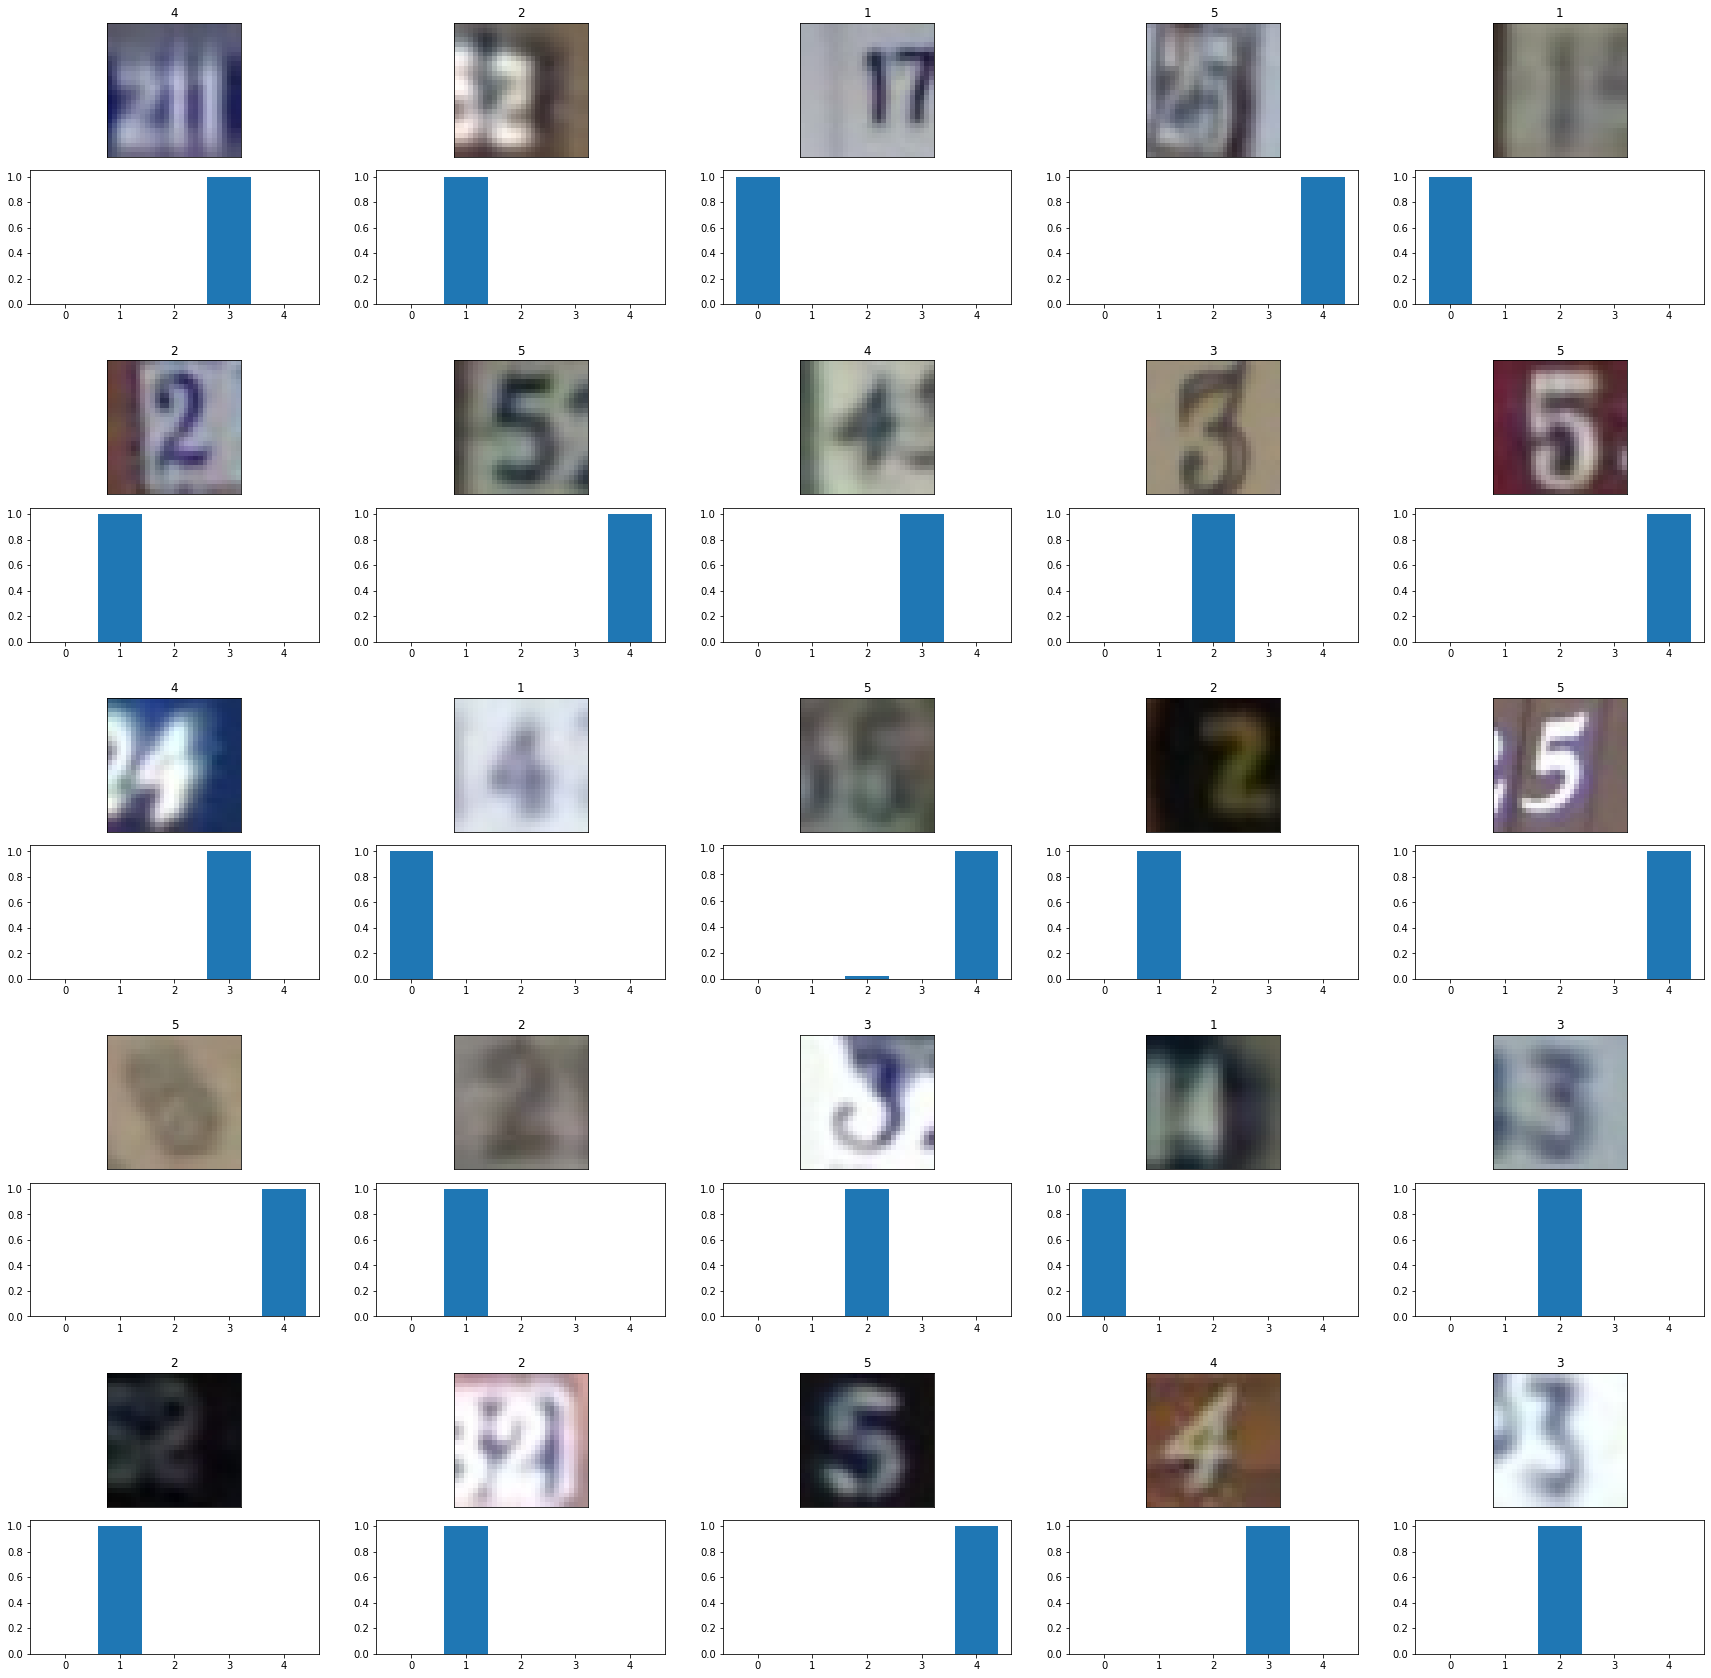

In [24]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model1.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(5)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4],pred_prob)
            fig.add_subplot(ax)


fig.show()

End of project